In [2]:
import datetime
import time
import io

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import solar_system_ephemeris,get_body_barycentric

import cairo
import imageio
from PIL import Image
from IPython.display import Image,display,clear_output,SVG

In [3]:
def svd_plane_normal(points):
    # matrix should be in shape:
    #[[x],
    # [y],
    # [z]]

    u,s,vh = np.linalg.svd(points)
    normal = u[:,2]

    return normal

def plane(coords,normal):
    x,y = coords
    return -(normal[0]*x + normal[1]*y)/normal[2]

In [4]:
def centroid(positions):
    return np.sum(positions,axis=0)/positions.shape[0]

In [5]:
def cart_to_polar(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi, z)

def polar_to_cart(rho, phi, z):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y, z)

In [6]:
solar_system_ephemeris.set('de438.bsp')

<ScienceState solar_system_ephemeris: 'de438.bsp'>

In [7]:
datetime.datetime.utcnow() + 2*datetime.timedelta(days=10)

datetime.datetime(2020, 8, 22, 6, 31, 34, 183228)

In [8]:
def get_2d_positions(start_time,time_delta,n_iter):
    positions_over_time = []
    for i in range(n_iter):
        #time_now = Time(datetime.datetime.utcnow(), scale='utc')
        positions=[]
        body_ignore=['earth-moon-barycenter','pluto']
        for body in solar_system_ephemeris.bodies:
            if body in body_ignore:
                continue
            pos = get_body_barycentric(body, start_time + time_delta*i).xyz.to(u.au)
            positions.append(pos.value)

        positions=np.array(positions)

        points = np.transpose(positions-centroid(positions))
        normal = svd_plane_normal(points)

        a = normal
        b = np.array([1,0,plane((1,0),normal)])
        c = b/np.linalg.norm(b)
        b = np.cross(a,b)

        coord_transform = np.vstack([c,b,a])

        new_points = []
        for row in np.transpose(points):
            new_points.append(np.dot(coord_transform,row+centroid(positions)))

        new_points = np.array(new_points)
        
        positions_over_time.append(new_points)
        
    return positions_over_time

In [9]:
time_now = Time(datetime.datetime.utcnow(), scale='utc')
positions=[]
body_ignore=['earth-moon-barycenter','pluto']
for body in solar_system_ephemeris.bodies:
    if body in body_ignore:
        continue
    pos = get_body_barycentric(body, time_now).xyz.to(u.au)
    positions.append(pos.value)
    
positions=np.array(positions)

In [10]:
points = np.transpose(positions-centroid(positions))
normal = svd_plane_normal(points)

In [11]:
a = normal
b = np.array([1,0,plane((1,0),normal)])
c = b/np.linalg.norm(b)
b = np.cross(a,b)

coord_transform = np.vstack([c,b,a])

In [12]:
new_points = []
for row in np.transpose(points):
    new_points.append(np.dot(coord_transform,row+centroid(positions)))

new_points = np.array(new_points)

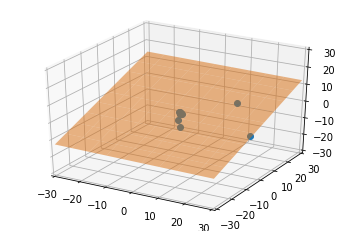

In [13]:
x = np.linspace(-30,30,10)
y = np.linspace(-30,30,10)

X,Y = np.meshgrid(x,y)
Z = plane((X,Y),normal)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*zip(*positions),linestyle='none',marker='o')
ax.plot_surface(X, Y, Z, alpha=0.5)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
plt.show()

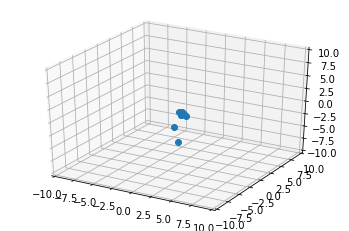

In [14]:
x = np.linspace(-30,30,10)
y = np.linspace(-30,30,10)

X,Y = np.meshgrid(x,y)
Z = plane((X,Y),normal)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*zip(*new_points),linestyle='none',marker='o')
#ax.plot_surface(X, Y, Z, alpha=0.5)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
plt.show()

In [15]:
polars=[]
for row in new_points:
    polars.append(cart_to_polar(*row))
    
polars = np.array(polars)

In [16]:
np.flip(polars[:,0:2],axis=1)

array([[ 2.26418816e+00,  8.75601622e-03],
       [ 9.61575798e-01,  3.14440396e-01],
       [-2.01717160e-01,  7.19831956e-01],
       [-8.62409878e-01,  1.00602514e+00],
       [-8.63145853e-01,  1.00848781e+00],
       [-4.18781007e-01,  1.37345468e+00],
       [-1.15080836e+00,  5.14136578e+00],
       [-1.06200027e+00,  1.00015788e+01],
       [ 6.60836995e-01,  1.97927663e+01],
       [-1.84009552e-01,  2.99229075e+01]])

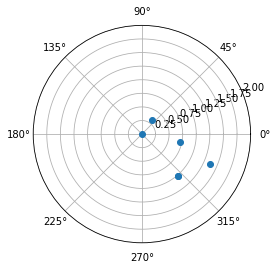

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

ax.plot(*zip(*np.flip(polars[:,0:2],axis=1)[0:6]),marker='o',linestyle='none')
ax.set_rlim(0,2)
plt.show()

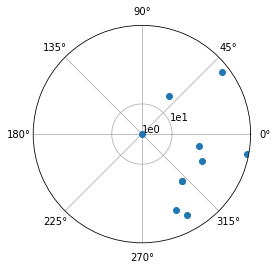

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

theta,r = zip(*np.flip(polars[:,0:2],axis=1))


min_log = np.log10(np.min(r))
max_log = np.log10(np.max(r))
max_log = np.log10(35)
r_log = np.log10(r) - min_log


ax.plot(theta,r_log,marker='o',linestyle='none')

l = np.arange(np.floor(min_log), max_log)

ax.set_rticks(l)
ax.set_yticklabels(["1e%d" % x for x in l])
ax.set_rlim(0, max_log - min_log)

plt.show()

In [19]:
positions_over_time = get_2d_positions(Time(datetime.datetime.utcnow(), scale='utc'),datetime.timedelta(days=1),100)

In [20]:
img_size = 400
au_width = 5
au_to_pix = img_size/au_width

border_stroke_width = 4
au_grid_stroke_width = 1
sun_radius = 4
sun_color = np.array([255,140,0])/255
mercury_color = np.array([169,169,169])/255

venus_color = np.array([229,195, 98])/255
earth_color = np.array([30,144,255])/255
mars_color = np.array([188,39,50])/255

dashed_line_color = [0,0,0,0.25]

black_color = [0,0,0,1]

body_colors = [sun_color,mercury_color,venus_color,earth_color,earth_color,mars_color]

mercury_size = 25

In [21]:
def draw_image(context, image, top, left, height, width):
    """Draw a scaled image on a given context."""
    image_surface = cairo.ImageSurface.create_from_png(image)
    # calculate proportional scaling
    img_height = image_surface.get_height()
    img_width = image_surface.get_width()
    width_ratio = float(width) / float(img_width)
    height_ratio = float(height) / float(img_height)
    scale_xy = min(height_ratio, width_ratio)
    # scale image and add it
    context.save()
    context.translate(left, top)
    context.scale(scale_xy, scale_xy)
    context.set_source_surface(image_surface,0,0)
    context.paint()
    context.restore()

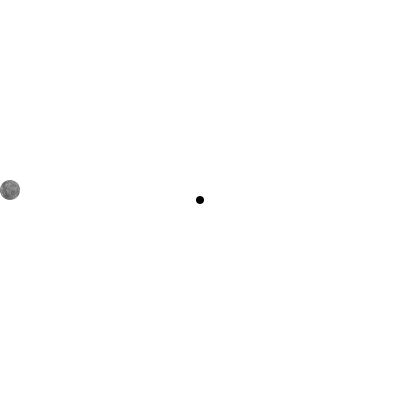

In [22]:
svgio = io.BytesIO()
with cairo.SVGSurface(svgio, img_size, img_size) as surface:
    context = cairo.Context(surface)

    context.arc(img_size/2,img_size/2, sun_radius, 0, 2*np.pi)
    context.fill()
    
    draw_image(context,'mercury.png',200-20,0,20,20)


SVG(data=svgio.getvalue())


In [23]:
for i,pos in enumerate(positions_over_time):
    surface = cairo.SVGSurface(None, img_size, img_size)
    context = cairo.Context(surface)
    
    context.set_line_width(border_stroke_width)
    context.arc(img_size/2,img_size/2, img_size/2 - border_stroke_width, 0, 2*np.pi)
    context.stroke()
    
    context.set_line_width(au_grid_stroke_width)
    context.set_dash([7,7])
    context.set_source_rgba(*dashed_line_color)
    context.arc(img_size/2,img_size/2, 1*au_to_pix, 0, 2*np.pi)
    context.stroke()
    context.set_dash([1,1])
    
    context.set_source_rgba(*black_color)

    
    (x, y, width, height, dx, dy) = context.text_extents("1 AU")
    context.move_to(img_size/2-width/2,img_size/2+height/2 - 1*au_to_pix)
    context.show_text("1 AU")
    
    text = 'Mars'
    (x, y, width, height, dx, dy) = context.text_extents(text)
    context.move_to(img_size-width-5,img_size-height-5)
    context.show_text(text)

    xys = (pos[:6,:2]*au_to_pix) + img_size/2

    for ii,(el,bc) in enumerate(zip(xys,body_colors)):
        if ii == 4:
            continue
        if ii == 5:
            #context.move_to(img_size/2, img_size/2)
            context.move_to(*el)
            context.line_to(img_size-width-5 - 4,img_size-height-5 + 4)
            context.set_source_rgba(1, 0, 0,1)
            context.set_line_width(2)
            context.stroke()
            context.move_to(img_size-width-5 - 4,img_size-height-5 + 4)
            context.line_to(img_size-width-5 + 2 + width,img_size-height-5 + 4)
            context.stroke()
            
        context.set_source_rgb(*bc)
        context.arc(*el, 4, 0, 2*np.pi)
        context.fill()
        
        if ii == 0:
            draw_image(context,'sun.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)
        
        if ii == 1:
            draw_image(context,'mercury.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)
        
        if ii == 2:
            draw_image(context,'venus.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)
        
        if ii == 3:
            draw_image(context,'earth.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)

        if ii == 5:
            draw_image(context,'mars.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)
            
        if ii == 6:
            draw_image(context,'jupiter.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)
        
        if ii == 7:
            draw_image(context,'saturn.png',el[1]-mercury_size/2,el[0]-mercury_size/2,mercury_size,mercury_size)



        
    context.set_source_rgb(0,0,0)

    context.set_source_rgba(0.0, 0.0, 0.0, 0.0)
    context.set_operator(cairo.OPERATOR_CLEAR)
    context.rectangle(0,0,img_size,img_size)
    context.set_operator(cairo.OPERATOR_OVER)
    
    surface.write_to_png(str(i)+'.png')

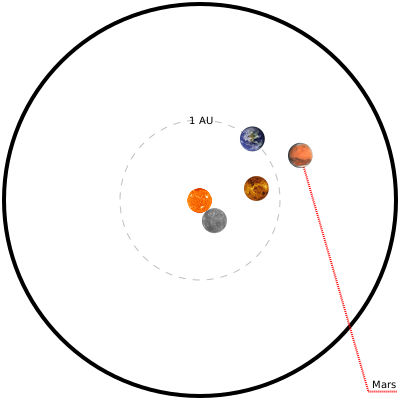

In [24]:
display(Image(filename='0.png'))

In [25]:
# check which way is right ccw or cw

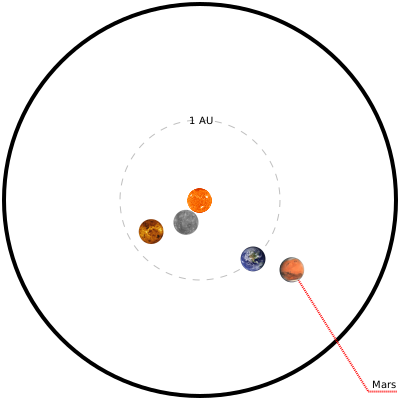

In [30]:
# jank way of displaying a series of png images
for i in range(len(positions_over_time)):
    display(Image(filename=str(i)+'.png'))
    clear_output(wait=True)
    time.sleep(0.02)
    